>>>> wez_dataset
        x0   x1            x2          x3          x4   x5          y
0       0    0  23993.258101  419.844500  109.627998    0  61.816406
1       0    0  35699.900474  692.667248    4.029763    0  12.949219
2       0    0  24230.691655  353.870903   87.244094    0  37.792969
3       0    0   4273.337463  245.155370  123.093129    0  60.292969
4       0    0  -1627.425138  554.487796  129.260288    0  22.207031
...    ..  ...           ...         ...         ...  ...        ...
24995   0    0  11849.599997  513.293154  176.197566    0  80.332031
24996   0    0  29720.289987  280.895315  175.950704    0  72.128906
24997   0    0   2790.021234  275.306766  177.982283    0  67.675781
24998   0    0  20884.832941  649.956635  176.809538    0  86.660156
24999   0    0   4888.751393  415.809521  174.985814    0  74.707031

[25000 rows x 7 columns]


>>>> filtered_wez_dataset
                  x2          x3          x4          y
0      23993.258101  419.844500  109.627998 

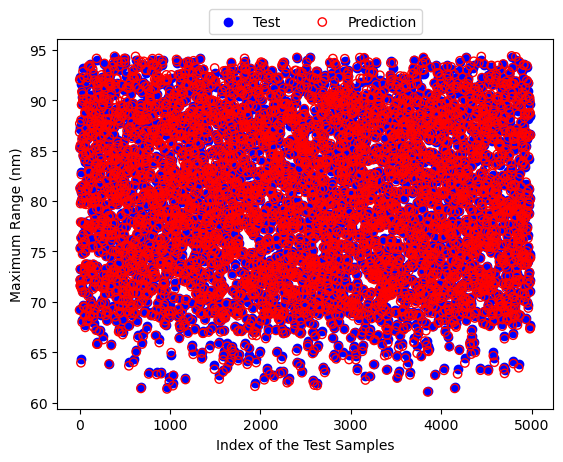

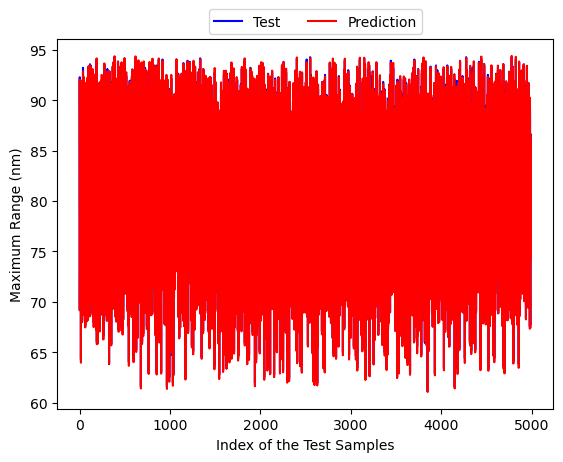

In [4]:
import numpy
import pandas
import math
import random
from matplotlib import pyplot
from numpy import arange

from sklearn.ensemble import RandomForestRegressor
#from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import set_config

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import time



seed = 13
numpy.random.seed(seed)

#-------------------------------------------------------------------------------------------------------------------------
# read the WEZ dataset
#wez_dataset = pandas.read_csv('wez_exp_out_full_9M96E2_python.csv')
wez_dataset = pandas.read_csv('wez_exp_out_full_48N6ES_python.csv')

print(">>>> wez_dataset\n", wez_dataset)
print("\n")

#-------------------------------------------------------------------------------------------------------------------------
# eliminate the columns 0, 1 and 5
filtered_wez_dataset = wez_dataset.copy()
filtered_wez_dataset.drop(filtered_wez_dataset.columns[[0, 1, 5]], axis=1, inplace=True)
print(">>>> filtered_wez_dataset\n",filtered_wez_dataset)
print("\n")

#-------------------------------------------------------------------------------------------------------------------------
# obtain the data
data = numpy.array(filtered_wez_dataset.iloc[:,:])
print(">>>> data\n", data)
number_lines = data.shape[0]
number_columns = data.shape[1]
print("number of lines =", number_lines)
print("number of columns =", number_columns)
print("\n")

#-------------------------------------------------------------------------------------------------------------------------
# normalize the WEZ dataset
# the column of the dependent variable y is not normalized
for ic in range(number_columns - 1):
    maximum_value = data[data[:,ic].argmax(),ic]
    minimum_value = data[data[:,ic].argmin(),ic]
    print("ic =", ic, "maximum_value =",maximum_value, "minimum_value =", minimum_value)
    for il in range(number_lines):
        data[il, ic] = (data[il, ic] - minimum_value) / (maximum_value - minimum_value)
print("\n")
print(">>>> normalized data\n", data)


#-------------------------------------------------------------------------------------------------------------------------
# filter the normalized data through the aspect angle.
data_filtered = []
for il in range(data.shape[0]):
    if (data[il][2] >= 0.0) and (data[il][2] <= 1.0):
        data_filtered.append(data[il])
data_filtered = numpy.array(data_filtered)       
print("\n")
print(">>>> filtered normalized data through aspect angle\n", data_filtered) 
print("number of lines of data_filtered =", data_filtered.shape[0])
print("number of colunms of data_filtered =", data_filtered.shape[1])

#-------------------------------------------------------------------------------------------------------------------------
# filter the normalized data eliminating the samples with negative values of y.
data_filtered_negative = []
for il in range(data_filtered.shape[0]):
    if (data_filtered[il][3] >= 0.0):
        data_filtered_negative.append(data_filtered[il])
data_filtered_negative = numpy.array(data_filtered_negative)
print("\n")
print(">>>> filtered normalized data through negative values of y\n", data_filtered_negative) 
print("number of lines of data_filtered_negative =", data_filtered_negative.shape[0])
print("number of colunms of data_filtered_negative =", data_filtered_negative.shape[1])

data = data_filtered_negative
number_lines = data.shape[0]
number_columns = data.shape[1]
print("number of lines =", number_lines)
print("number of columns =", number_columns)

#-------------------------------------------------------------------------------------------------------------------------
# define X and Y as the set of values for the independent and dependent variables
X = data[:,:(number_columns-1)]
Y = data[:,(number_columns-1)]

#-------------------------------------------------------------------------------------------------------------------------
# define the training and validation datasets
# observation: the training dataset is created with 80% of the data.
number_lines_training = int(0.8 * number_lines)
X_training = X[:number_lines_training,:]
Y_training = Y[:number_lines_training]
print("\n")
print(">>>> X_training\n", X_training)
print("number of lines of X_training =", X_training.shape[0], "number of columns of X_training =", X_training.shape[1])
print("\n")
print(">>>> Y_training\n", Y_training)
print("number of elements of Y =", Y_training.shape[0])

X_test = X[number_lines_training:,:]
Y_test = Y[number_lines_training:]
print("\n")
print(">>>> X_test\n", X_test)
print("number of lines of X_test =", X_test.shape[0], "number of columns of X_test =", X_test.shape[1])
print("\n")
print(">>>> Y_test\n", Y_test)
print("number of elements of Y_test =", Y_test.shape[0])





#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------
#           TRAINING
#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------
number_experiments = 5

kf = KFold(n_splits=number_experiments, shuffle=True, random_state=seed)

somatory_mse = 0.0
somatory_mpe = 0.0
somatory_r_squared = 0.0
somatory_rmse = 0.0
somatory_delta_time = 0.0

cvscores = []
for i, (train_index, validation_index) in enumerate(kf.split(X_training)):
    
    print("\n")
    print("--------> iteration =", (i+1))
    
    start_time = time.time() # in seconds
    
    X_training_kfold = X_training[train_index]
    Y_training_kfold = Y_training[train_index]
    
    X_validation_kfold = X_training[validation_index]
    Y_validation_kfold = Y_training[validation_index]
    
    #print("--------> Y_validation_kfold.shape[0] =",Y_validation_kfold.shape[0])
    
    # create model
    rfr = RandomForestRegressor(n_estimators = 100)
    
    # Fit the model
    rfr.fit(X_training_kfold, Y_training_kfold)
    
    # evaluate the model
    score_kfold = rfr.score(X_validation_kfold, Y_validation_kfold)
    print("R-squared:", score_kfold)
    
    Y_predicted_kfold = rfr.predict(X_validation_kfold)

    mse = mean_squared_error(Y_validation_kfold, Y_predicted_kfold)
    print("MSE: ", mse)
    rmse = mean_squared_error(Y_validation_kfold, Y_predicted_kfold, squared=False)
    print("RMSE: ", rmse)
    
    end_time = time.time() # in seconds
    
    somatory_percentage_error = 0.0

    for i in range(Y_predicted_kfold.shape[0]):
    
        percentage_error = abs(Y_predicted_kfold[i] - Y_validation_kfold[i]) / Y_validation_kfold[i]
        
        somatory_percentage_error = somatory_percentage_error + percentage_error
    
    mpe = somatory_percentage_error / Y_predicted_kfold.shape[0]
    print("MPE: ", mpe)
    
    delta_time = (end_time - start_time)
    print("training time interval of the fold (s): ", delta_time)
    
    somatory_r_squared = somatory_r_squared + score_kfold
    somatory_mse = somatory_mse + mse    
    somatory_mpe = somatory_mpe + mpe
    somatory_rmse = somatory_rmse + rmse
    somatory_delta_time = somatory_delta_time + delta_time
    
    cvscores.append(score_kfold * 100)
    
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

print("\n")
print("----> TRAINING <----")
mean_mse = somatory_mse / number_experiments

print("mean of the Mean Squared Error (MSE) =", mean_mse)

mean_rmse = somatory_rmse / number_experiments

print("mean of the Root of Mean Squared Error (RMSE) =", mean_rmse)

mean_mpe = somatory_mpe / number_experiments

print("mean of the Mean Percent Error (MPE) =", mean_mpe)

mean_r_squared = somatory_r_squared / number_experiments

print("mean of the R-Squared =", mean_r_squared)

mean_delta_time = somatory_delta_time / number_experiments

print("mean of the training time interval (s) =", mean_delta_time)




#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------
#           TEST
#---------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------
print("\n")
print("----> TEST <----")

# create model
rfr = RandomForestRegressor(n_estimators = 100)
    
# Fit the model
rfr.fit(X_training, Y_training)

# evaluate the model
score = rfr.score(X_test, Y_test)
print("R-squared (R2) =", score)

start_time = time.time() # in seconds
Y_predicted = rfr.predict(X_test)
end_time = time.time() # in seconds
delta_time = (end_time - start_time)

rmse = mean_squared_error(Y_test, Y_predicted, squared=False)
print("Root Mean Squared Error (RMSE) =", rmse)

mse = mean_squared_error(Y_test, Y_predicted)
print("Mean Squared Error (MSE) =", mse)
    
somatory_percentage_error = 0.0

for i in range(Y_predicted.shape[0]):
    
    percentage_error = abs(Y_predicted[i] - Y_test[i]) / Y_test[i]
        
    somatory_percentage_error = somatory_percentage_error + percentage_error
    
mpe = somatory_percentage_error / Y_predicted.shape[0]
print("Mean Percent Error (MPE) =", mpe)

print("validation time interval (s): ", delta_time)


X_sequence = arange(0, (Y_test.shape[0]), 1)
pyplot.scatter(X_sequence, Y_test, label ='Test', color= "blue")
pyplot.scatter(X_sequence, Y_predicted,  label ='Prediction', facecolors='none', color ="red")
pyplot.ylabel("Maximum Range (nm)")
pyplot.xlabel("Index of the Test Samples")
pyplot.legend(bbox_to_anchor =(0.75, 1.1), ncol = 2)
pyplot.show()

pyplot.plot(Y_test, label ='Test', color='blue')
pyplot.plot(Y_predicted, label ='Prediction', color='red')
pyplot.ylabel("Maximum Range (nm)")
pyplot.xlabel("Index of the Test Samples")
pyplot.legend(bbox_to_anchor =(0.75, 1.1), ncol = 2)
pyplot.show()